# Denoising Diffusion Probabilistic Models
#### Author: Zsolt Pajor-Gyulai

This notebook walks through implementing a Denoising Diffusion Probabilistic Model (DDPM) as defined by

```
@inproceedings{NEURIPS2020_4c5bcfec,
    author      = {Ho, Jonathan and Jain, Ajay and Abbeel, Pieter},
    booktitle   = {Advances in Neural Information Processing Systems},
    editor      = {H. Larochelle and M. Ranzato and R. Hadsell and M.F. Balcan and H. Lin},
    pages       = {6840--6851},
    publisher   = {Curran Associates, Inc.},
    title       = {Denoising Diffusion Probabilistic Models},
    url         = {https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf},
    volume      = {33},
    year        = {2020}
}
```

with improvements proposed by 

```
@InProceedings{pmlr-v139-nichol21a,
    title       = {Improved Denoising Diffusion Probabilistic Models},
    author      = {Nichol, Alexander Quinn and Dhariwal, Prafulla},
    booktitle   = {Proceedings of the 38th International Conference on Machine Learning},
    pages       = {8162--8171},
    year        = {2021},
    editor      = {Meila, Marina and Zhang, Tong},
    volume      = {139},
    series      = {Proceedings of Machine Learning Research},
    month       = {18--24 Jul},
    publisher   = {PMLR},
    pdf         = {http://proceedings.mlr.press/v139/nichol21a/nichol21a.pdf},
    url         = {https://proceedings.mlr.press/v139/nichol21a.html},
}
```

While Diffusion Models were proposed earlier by [Sohl-Dickstein et al (2015)](), the [Ho et al. (2020)]() paper was the one that showed that it can produce reasonable image quality. [Nichol & Dhariwal]() proposed several improvements that went a long way in closing the gap with GAN-s.

In [116]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, ToPILImage

import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

# Datasets

To keep the computational burden at a minimum, we are going to start with CIFAR-10, a collection of 60K tiny 32x32 images.

### Dowloading and inspecting data

In [55]:
# Downloading data
print("Downloading CIFAR10")
train_dataset = CIFAR10(
      root = "./datasets",
      transform = ToTensor(),
      train = True,
      download = True)
test_dataset = CIFAR10(
      root = "./datasets",
      transform = ToTensor(),
      train = False,
      download = True)

print(f"CIFAR10 dataset downloaded from {train_dataset.url} to {train_dataset.root}/{train_dataset.base_folder}")

Files already downloaded and verified
Files already downloaded and verified
CIFAR10 dataset downloaded from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./datasets/cifar-10-batches-py


Training data: (50000, 32, 32, 3)
Test data: (10000, 32, 32, 3)
Samples: 


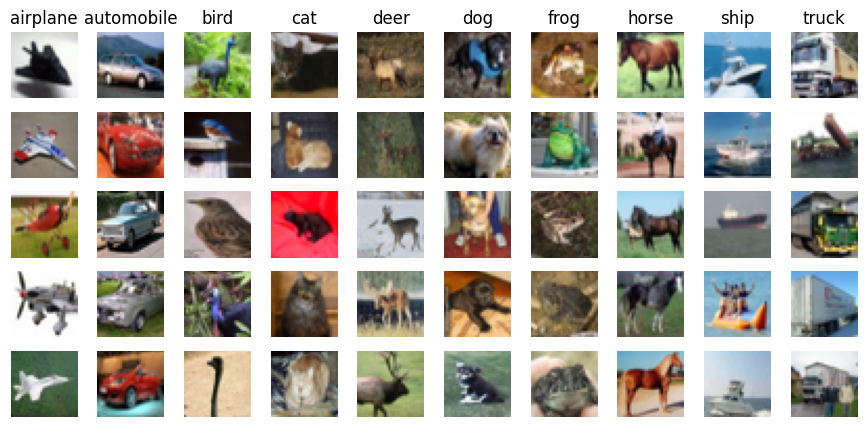

In [66]:
# Peek into data

print(f"Training data: {train_dataset.data.shape}")
print(f"Test data: {test_dataset.data.shape}")

CLASSES = [cls for cls in train_dataset.class_to_idx]
CLASS_TO_IDX = train_dataset.class_to_idx
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

print("Samples: ")

# Get 10 sample images from each class
fig, axs = plt.subplots(5, 10, figsize=(11,5))
counter = Counter()
i=0
while counter.total() < 50:
  img, label = train_dataset[i]
  i += 1
  if counter[label] < 5:
    ax = axs[counter[label], label]
    counter[label] += 1

    ax.axis('off')
    ax.imshow(img.permute(1, 2, 0))

    if counter[label] == 1:
      ax.set_title(f"{IDX_TO_CLASS[label]}")

plt.show()

### Creating a data loader

In [483]:
BATCH_SIZE = 128
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_CHANNELS = 3

train_dataloader = DataLoader(
      dataset=train_dataset,
      batch_size = 128,
      shuffle=True)
test_dataloader = DataLoader(
      train_dataset,
      batch_size = 128,
      shuffle=True)

## Denoising Diffusion Models

#### Diffusions as latent variable models

We are going to implement the Denoising Diffusion Probabilistic Model (DDPM) from scratch. This model proposes a latent variable structured as the trajectory of a Markov chain $z = (x_1, \dots, x_T)\in \mathbb{R}^{T\times 3\times 32\times 32}$ that is, all $x_i$ have the same size as the original image, conveniently denoted as $x_0$. 

Unlike other latent variable models, the prior $p(z)$ is partly learnable. Namely, we prescribe $p(x_T)$ to be a standard, isotropic Gaussian variable and the rest of the distribution is a Markov chain of Gaussian transitions with learnable means and variances. That is,

$$ p_{\theta}(x_{t-1}| x_t) = \mathcal{N}\left(x_{t-1};\mu_{\theta}(x_t, t), \Sigma_\theta(x_t, t)\right) $$

The model probability can thus be described by

$$ p_{\theta}(x_0) = \int dx_{1:T}p(x_T)\prod_{t=1}^{T}p_\theta(x_{t-1} | x_t) (*)$$

We want to train this model to approximate the data distribution $q(x_0)$. The most common way to do this is to measure how many bits of information would we use to encode an average image if we devised an encoding scheme optimized for the probabilities. This is also known as the expected negative log-likelihood loss:

$$ L =  -\mathbb{E}_{q(x_0)}\log p_{\theta}(x_0). $$

Unfortunately, the integral in (*) is intractable analytically and sampling from it naively would be hopelessly high variance for estimating LL. Just like for VAEs, importance sampling comes to the rescue with a proposal distribution that is ideally the posterior distribution of $x_{1:T}$ given the observed data $x_0$. We choose to be a simple Markov chain 

$$q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_{t}|x_{t-1}), $$

where $q(x_t|x_{t-1}) = \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1}, \beta_t I) $, where $\sqrt{1-\beta_t}$ was chosen to keep the level of noise at a steady rate. The $\beta_t$ is called the *noise schedule* and is an important hyperparameter of the setup. With this, we can write

$$ p_{\theta}(x_0) = \int dx_{1:T}q(x_{1:T}|x_0)\prod_{i=1}^{T}p(x_T)\frac{p_\theta(x_{i-1} | x_i)}{q(x_i|x_{i-1})} $$

which one can evaluate by sampling from $q$ now. The hope is that resulting estimate of the negative log-likelihood will be much lower variance:

$$
L = - \int dx_0 q(x_0)\log \left[ \int dx_{1:T}q(x_{1:T}|x_0)\prod_{i=1}^{T}p(x_T)\frac{p_\theta(x_{i-1} | x_i)}{q(x_i|x_{i-1})}\right].
$$

The problem is that due to the presence of the $\log$, the sampled estimate would be badly biased and we need one more trick. This is commonly known as the Evidence Lower Bound (ELBO) and is nothing else but applying Jensen's inequality:

$$
L \leq  - \int dx_{0:T} q(x_{0:T})\log \left[\prod_{i=1}^{T}p(x_T)\frac{p_\theta(x_{i-1} | x_i)}{q(x_i|x_{i-1})}\right]  = ELBO,
$$

where equality holds if all the terms under the $\log$ are constants along the trajectory $x_{1:T}$:

$$ 
\prod_{i=1}^{T}p(x_T)\frac{p_\theta(x_{i-1} | x_i)}{q(x_i|x_{i-1})} = const\qquad\to\qquad q(x_{1:T}|x_0) = p_{\theta}(x_{1:T}|x_0), 
$$

that is, the *forward process* $q$ should be the posterior of the *backwards process* $p_{\theta}$ under the observed image $x_0$. We will train a neural network to output $p_\theta(x_{t-1}|x_t)$ such that this is approximated as best as possible. In an ideal situation, the ideally best possible ELBO bound will also close the *variational gap* between $L$ and $ELBO$.

#### The forward process and the variance schedule

As we describe above, the ELBO loss can be evaluated by sampling from the forward process $q$. This means taking some random examples $x_0$ from the dataset and sampling the Markov chain once we have fixed $\beta_t$-s. The version originally proposed by [Ho et al. (2020)] was to linearly increase the schedule. For a time being, we will use $T=1000$ (although [Nichol & Dhariwal (2021)] found that $T=4000$ lead to better outcomes in the end).

In [367]:
T = 1000

def get_linear_schedule(T: int) -> np.array:
    """
    Get the linear schedule.
    """
    scale = 1000 / T
    beta_1 = scale * 0.0001
    beta_T = scale * 0.02
    return np.hstack((0, np.linspace(beta_1, beta_T, T, dtype = np.float64)))

betas_linear =  get_linear_schedule(T)

We can now create samples from the forward process, but before we do that, note that to get a sample at $t$, the simple structure of the process allows us to do it in one step. To see this, let us introduce

$$ \alpha_t = 1-\beta_t,\qquad \bar{\alpha}_t = \prod_{s=1}^t \alpha_s $$

and note that by the properties of independent Gaussian increments is that their total is also Gaussian:

$$ q(x_t|x_0) = \int dx_{1:t-1}\prod_{s=1}^tq(x_s|x_{s-1}) = \mathcal{N}\left(x_t; \sqrt{\bar{\alpha}_t}x_0; (1-\bar\alpha_t) I\right).$$

In practice, we will sample from this distribution using the *reparametrization trick* which is just a representation of a Gaussian:

$$ x_t = \sqrt{\bar\alpha_t} + \sqrt{1-\bar\alpha_t}\varepsilon_t, \qquad \varepsilon\sim\mathcal{N}(0, I) $$

We visualized the injected cumulative variance schedule on the next plot. Note that we start and end flat and have a region in the middle of linear growth for the cumulative variance.

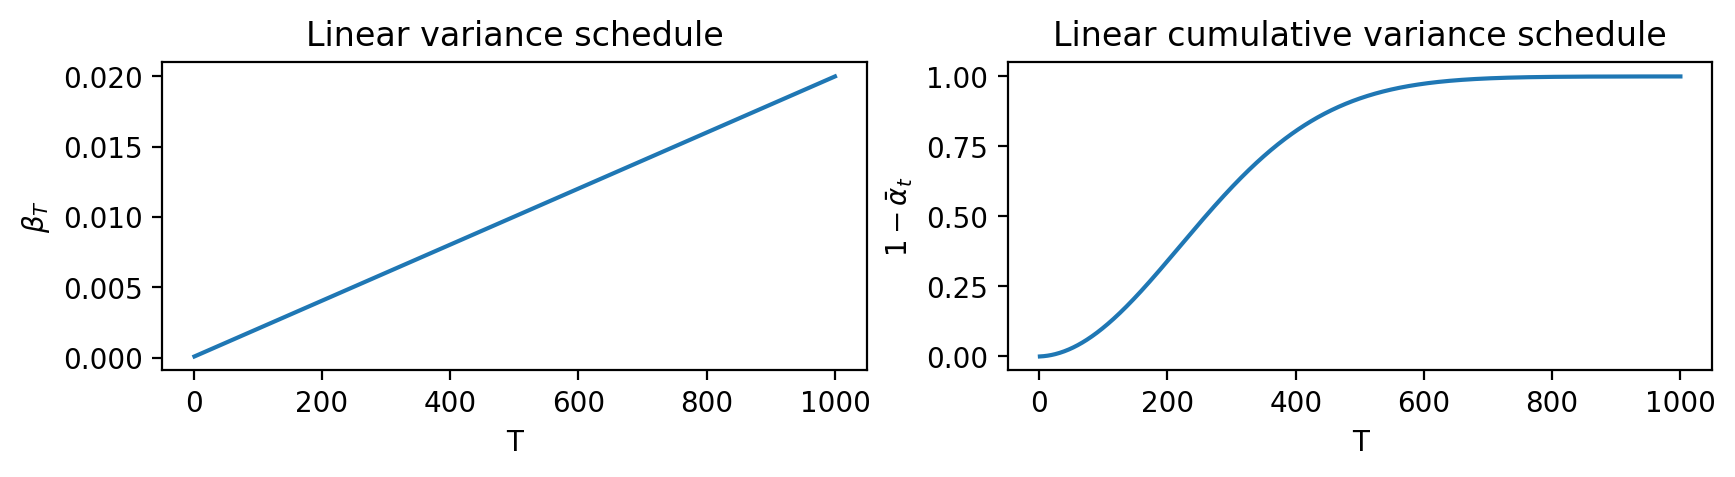

In [295]:
# Linear variance schedule
alphas_linear = 1.0 - betas_linear
alphas_linear_cumprod = np.cumprod(alphas_linear, axis=0)

fig, axes = plt.subplots(ncols=2, figsize = (10, 2), dpi = 200)
axes[0].plot(np.arange(1, T+1, dtype=np.float64), betas_linear[1:])
axes[1].plot(np.arange(1, T+1, dtype=np.float64), 1 - alphas_linear_cumprod[1:])
axes[0].set_title(r"Linear variance schedule")
axes[1].set_title(r"Linear cumulative variance schedule")
axes[0].set_xlabel("T"); axes[1].set_xlabel("T")
axes[0].set_ylabel(r"$\beta_T$")
axes[1].set_ylabel(r"$1-\bar\alpha_t$")
plt.show()

We can now sample from these on some example images:

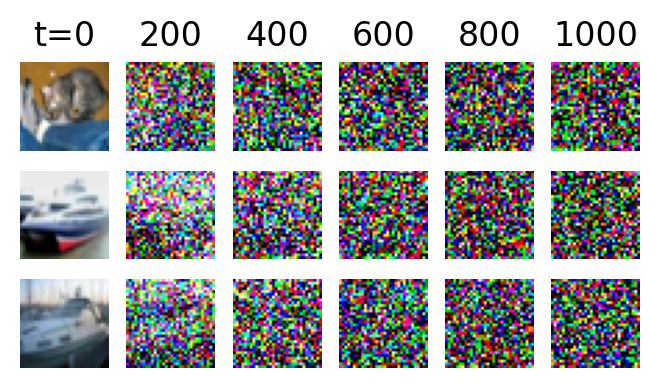

In [296]:
# Sample noised images
EXAMPLES = 3

example_images = torch.stack([test_dataset[i][0] for i in range (EXAMPLES)])

fig, axes = plt.subplots(nrows = EXAMPLES, ncols = 6, dpi = 200, figsize = (4, 2))
for i, t in enumerate(np.linspace(0, T, 6, dtype = np.int64)):
    alpha_bar = alphas_linear_cumprod[t]
    noise = torch.randn_like(example_images) # Images are in the scale 0..1
    noised_image = np.sqrt(alpha_bar) * example_images + np.sqrt(1-alpha_bar) * noise
    clipped_noised_image = np.clip(noised_image, 0, 1)

    for ex in range(EXAMPLES):
        axes[ex, i].imshow(clipped_noised_image[ex].permute(1, 2, 0))
        axes[ex, i].axis("off")
        
    if t == 0:
        axes[0, i].set_title(f"t={t}")
    else:
        axes[0, i].set_title(f"{t}")

plt.show()

As we see, at $t=200$, these images are already plenty noisy and [Nicol & Dhariwal (2021)] found that there isn't enough signal left for the model to learn from. Therefore they proposed to use what they dubbed the *cosine schedule* prescribed in cumulative terms:

$$ \bar \alpha_t = \frac{f(t)}{f(0)}, \qquad f(t) = \cos\left(\frac{t/T +s}{1+s}\frac{\pi}{2}\right)^2 $$

In order to avoid total destruction of the signal, we clip the betas at a number less than one.

In [297]:
def get_cosine_alphabar_schedule(T: int, smoothing: float = 0.008, max_beta=0.999) -> np.ndarray:
    f = lambda t: np.cos((t + smoothing) / (1+smoothing) * np.pi / 2) ** 2
    norm = f(0)

    betas = []
    for i in range(T):
        t1 = i / T
        t2 = (i + 1) / T

        alphabar1 = f(t1) / norm
        alphabar2 = f(t2) / norm
        betas.append(min(1 - alphabar2 / alphabar1, max_beta))
    return np.hstack((0, np.array(betas)))

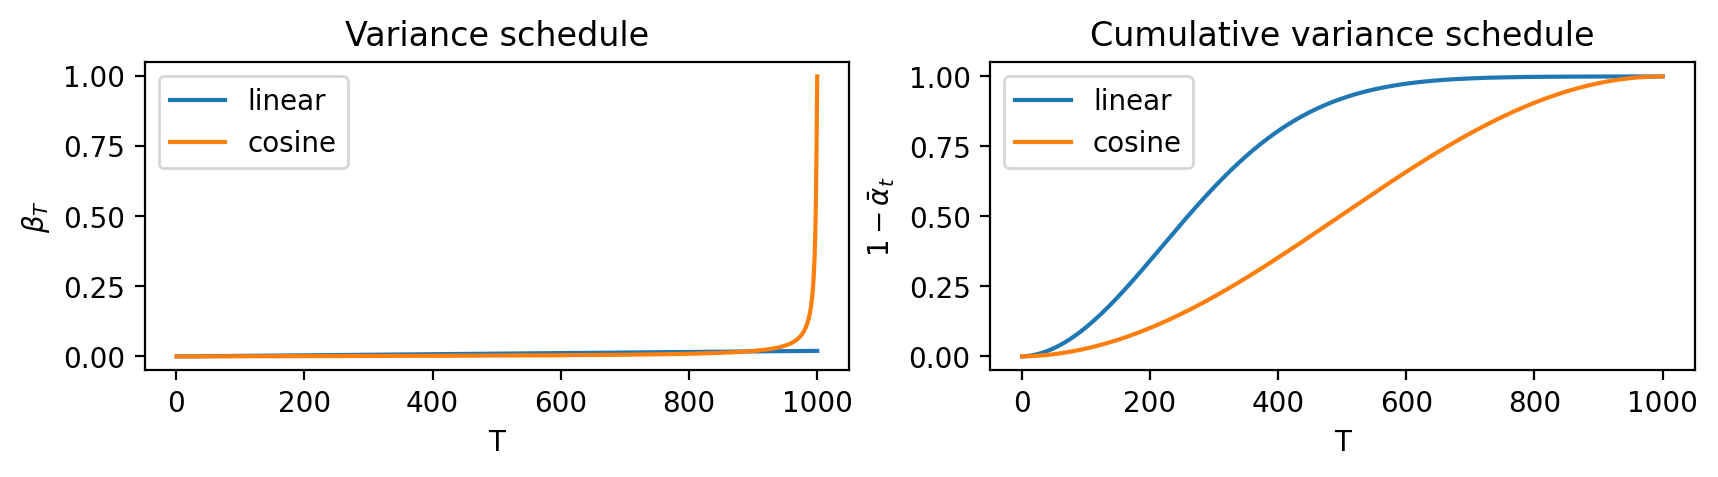

In [298]:
# Cosine variance schedule
betas_cosine = get_cosine_alphabar_schedule(T)
alphas_cosine = 1.0 - betas_cosine
alphas_cosine_cumprod = np.cumprod(alphas_cosine, axis=0)

fig, axes = plt.subplots(ncols=2, figsize = (10, 2), dpi = 200)
axes[0].plot(np.arange(1, T+1, dtype=np.float64), betas_linear[1:], label="linear")
axes[0].plot(np.arange(1, T+1, dtype=np.float64), betas_cosine[1:], label="cosine")
axes[0].legend()
axes[1].plot(np.arange(1, T+1, dtype=np.float64), 1-alphas_linear_cumprod[1:], label="linear")
axes[1].plot(np.arange(1, T+1, dtype=np.float64), 1-alphas_cosine_cumprod[1:], label="cosine")
axes[1].legend()

axes[0].set_title(r"Variance schedule")
axes[1].set_title(r"Cumulative variance schedule")
axes[0].set_xlabel("T"); axes[1].set_xlabel("T")
axes[0].set_ylabel(r"$\beta_T$")
axes[1].set_ylabel(r"$1-\bar\alpha_t$")
plt.show()

This shows that the cosine schedule is not that eager to destroy the signal which shows in the images as well, e.g. at $t=500$ we are replacing roughly half of the signal with noise, which already looks pretty noisy:

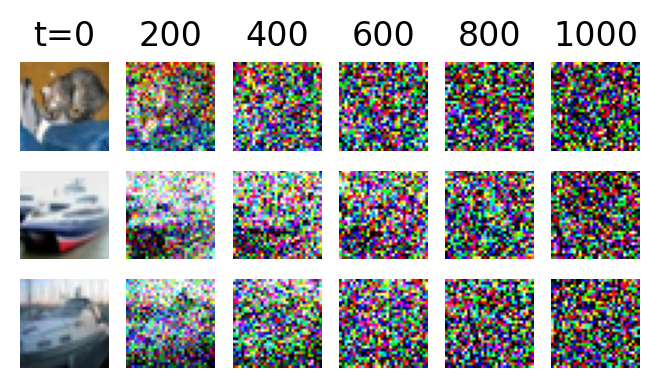

In [301]:
# Sample noised images
EXAMPLES = 3

example_images = torch.stack([test_dataset[i][0] for i in range (EXAMPLES)])

fig, axes = plt.subplots(nrows = EXAMPLES, ncols = 6, dpi = 200, figsize = (4, 2))
for i, t in enumerate(np.linspace(0, T, 6, dtype = np.int64)):
    alpha_bar = alphas_cosine_cumprod[t]
    noise = torch.randn_like(example_images) # Images are in the scale 0..1
    noised_image = np.sqrt(alpha_bar) * example_images + np.sqrt(1-alpha_bar) * noise
    clipped_noised_image = np.clip(noised_image, 0, 1)

    for ex in range(EXAMPLES):
        axes[ex, i].imshow(clipped_noised_image[ex].permute(1, 2, 0))
        axes[ex, i].axis("off")
        
    if t == 0:
        axes[0, i].set_title(f"t={t}")
    else:
        axes[0, i].set_title(f"{t}")

plt.show()

Here we can still kind of makes up artifacts of the original image. For this reason, we are going to use the cosine schedule for the rest of this notebook.

#### Baseline loss with a random Gaussian model
Having this allows us to establish a baseline for our loss using random samples from the forward process using some brute force Monte-Carlo and a random model which we choose to output a standard random Gaussian at each step independently of its input. For the exact negative log-likelihood, this is easily

$$ L = - \frac{1}{B}\sum_{b=1}^B \log p_{\theta}(x_0^b) $$

For the ELBO, however, we will sample the entire trajectory (from the same $x_0^b)$:

$$ ELBO \approx - \frac{1}{B}\sum_{b=1}^B \log \left[\prod_{t=1}^{T}p(x_T^{b})\frac{p_\theta(x_{t-1}^{b} | x_t^{b})}{q(x_t^{b}|x_{t-1}^{b})}\right] = - \frac{1}{B}\sum_{b=1}^B \left[\log p(x_T^b) + \sum_{t=1}^T\log p_\theta(x_{t-1}^{b} | x_t^{b}) - \log q(x_t^{b}|x_{t-1}^{b})\right]  $$

Note that if $\varphi(x; \mu, \sigma^2 I)$ is the isotropic Gaussian pdf, then 

$$ \log\varphi(x;\mu, \sigma^2 I) = -\frac{1}{2\sigma^2}\|x - \mu\|^2 + \frac{D}{2}\log (2\pi\sigma^2)  $$ 

and the NLL becomes:

$$ L = \frac{1}{B}\sum_{b=1}^B\left[\frac{1}{2}\|x_0^b\|^2 + \frac{D}{2}\log (2\pi)\right] = \frac{1}{2B}\sum_{b=1}^B\|x_0^b\|^2  + \frac{D}{2}\log(2\pi)$$

Similarly, we can write ELBO as

$$ELBO \approx  \frac{1}{2B}\sum_{b=1}^B \left[\sum_{t=0}^T \left[\|x_{t}^b\|^2 + \frac{D}{2}\log(2\pi)\right]- \sum_{t=1}^T \left[\frac{1}{\beta_t} \|x_t^b - \sqrt{1-\beta_t}x_{t-1}^b\|^2 + D\log(2\pi \beta_t)\right]\right] $$

which can be written as

$$\frac{1}{2B}\sum_{b=1}^B \left[\ \|x_{0}^b\|^2 + D\log(2\pi) + \sum_{t=1}^T\left[ \|x_{t}^b\|^2 -  \frac{1}{\beta_t} \|x_t^b - \sqrt{1-\beta_t}x_{t-1}^b\|^2-D\log\beta_t\right]\right]  $$

In [ ]:
# Forward sampling function
def sample_forward_trajectory(x0: torch.Tensor, beta_schedule: np.ndarray):
    """
    x0 : C x H x W array like
    beta_schedule : 1D array of length T
    
    Returns:
        (T+1) x C x H x W
    """
    T = len(beta_schedule)
    xts = [x0]
    for t in range(T):
        beta = beta_schedule[t]
        noise = np.random.randn(*x0.shape)
        xts.append(np.sqrt(1-beta) * xts[-1] + np.sqrt(beta) * noise)

    return np.stack(xts, axis = 0)

In [488]:
# Monte Carlo estimation of the losses of random models
B = 100
qhat_idx = np.random.randint(0, len(train_dataset)-1, B)
betas = betas_cosine

IMAGE_SIZE = IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_CHANNELS

likelihoods = []
elbos = []

for b in range(B):
    x0 = train_dataset[qhat_idx[b]][0].numpy()
    x0_nsq = (x0 * x0).sum()

    elbo = x0_nsq.copy()
    trajectory = sample_forward_trajectory(x0, betas[1:])

    for t in range(1, T):
        xt = trajectory[t]
        xtm1 = trajectory[t-1]
        betat = betas[t]

        xt_nsq = (xt * xt).sum()
        xt_diff = xt - np.sqrt(1-betat) * xtm1
        xt_diff_nsq =  (xt_diff * xt_diff).sum()
        
        elbo += xt_nsq - xt_diff_nsq / betat - (IMAGE_SIZE) * np.log(betat)
    
    likelihoods.append(x0_nsq/2)
    elbos.append(elbo/2)

nll = sum(likelihoods)/B + (IMAGE_SIZE / 2) * np.log(2*np.pi)
nelbo = sum(elbos)/B + (IMAGE_SIZE / 2) * np.log(2*np.pi)

print(f"Random model NLL loss based on {B} samples: {nll}")
print(f"Random model ELBO loss based on {B} samples: {nelbo}")

Random model NLL loss based on 100 samples: 3236.974785996637
Random model ELBO loss based on 100 samples: 8257877.054030032


We see that as expected, the elbow bound is very very far above the NLL and both are pretty bad figures, let's beat them!

#### The backwards process and how should we learn this?

The ELBO loss above clearly splits up into a sum of terms that only involves one transition. We separate out the boundary terms to treat the edge effects separately

$$
ELBO = -\mathrm{E}_q\log p(x_T) -\sum_{t=2}^T\mathrm{E}_q\log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} - \mathbb{E}_q\log\frac{p_\theta(x_0 | x_1)}{q(x_1|x_0)}.
$$

The first term here is not trainable and essentially measures how far $q(x_T)$ is from an isotropic Gaussian. The key, no so surprisingly will be the middle sum of terms. The keen observer might notice that these terms almost KL divergences except that they are not distributions in the same variable. This can be easily fixed by applying Bayes' theorem to $q$ but with the added twist of noting $q(x_t|x_{t-1})=q(x_t|x_{t-1}, x_0)$ due to the Markov property. This is important because this way $q(x_{t-1}|x_t, x_0)$  is Gaussian (note that not conditioning on $x_0$ yields distribution that involves $q(x_0)$ and is thus non-Gaussian in general) and we have

$$ \mathbb{E}_q\log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} = \mathbb{E}_q\log\frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_t, x_0)} + \mathbb{E}_q \log\frac{q(x_{t-1}|x_0)}{q(x_{t}|x_0)}, $$

From the second term, only the denominator for $t=T$ and the numeratorfor $t=2$ survive the subsequent summation.

### The model architecture

## Training

In [ ]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


In [ ]:
T = 10
for i in range(example_images.shape[0]):
    for 
    noise = torch.randn_like(x_start)

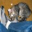

In [122]:
ToPILImage()(example_images[0])

#### Modelling the transition function

Note that the ELBO loss decomposes to a product

$$
ELBO = -\mathrm{E}_q\log p(x_T) -\sum_{t=2}^T\mathrm{E}_q\log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} - \mathbb{E}_q\log\frac{p_\theta(x_0 | x_1)}{q(x_1|x_0)}
$$

In [114]:
# Create a miniature batch of example images for testing
example_images = torch.stack([test_dataset[i][0] for i in range (3)])
example_images.shape

torch.Size([3, 3, 32, 32])

In [112]:
class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2):
        super().__init__()
        self.channels = channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = nn.conv_nd(dims, channels, channels, 3, stride=stride, padding=1)
        else:
            self.op = nn.avg_pool_nd(stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)

In [113]:
Downsample(channels = 2, use_conv = True)

AttributeError: module 'torch.nn' has no attribute 'conv_nd'